# Doyle-Fuller-Newman Model with particle-size distributions

This notebook demonstrates the extension of the Doyle-Fuller-Newman (DFN) model to include a distribution of particle sizes at every macroscale location (e.g. through-cell coordinate $x$) within the electrodes. This model, referred to here as the Many-Particle DFN (or MP-DFN), also extends the ideas of the Many-Particle Model or MPM (an $x$-averaged model) into the DFN framework. Note: this differs from a "size distribution in x", where the particle size is a function of $x$ but with only a single size at any given value of $x$.

The [MPM notebook](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/models/MPM.ipynb) describes how the particle-size distributions are implemented in PyBaMM, and how to input parameters and plot some relevant output variables. The model equations for the MP-DFN, which allow for variations in the through-cell $x$ direction and therefore include electrolyte dynamics, are similar to those of the MPM and DFN, and are available in [[5]](#References).

By default per electrode, the DFN has 1 microscale dimension (the radial coordinate within the active particles, $r_{\mathrm{k}}$, $\mathrm{k}=\mathrm{n,p}$) and 1 macroscale dimension (the through-cell coordinate $x$), and is commonly called "pseudo-2D". The MP-DFN adds another microscale variation with particle size $R_{\mathrm{k}}$, $\mathrm{k}=\mathrm{n,p}$ over an interval $[R_{\mathrm{k,min}}, R_{\mathrm{k,max}}]$, $\mathrm{k}=\mathrm{n,p}$, and thus can be thought of as "pseudo-3D". See [[5]](#References) for more details. 

## Example solving the MP-DFN

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


The MP-DFN can be accessed from the `DFN` model in PyBaMM, and specifying the `"particle size"` option. The default option for `"particle size"` is `"single"`. Let's change this to `"distribution"` and pass to the `DFN` when loading the model.

In [2]:
# choose option(s)
options = {"particle size": "distribution"}

# load model
model = pybamm.lithium_ion.DFN(options=options, name="MP-DFN")

## Adding size distribution parameters

We now need to input and set the particle-size distributions and the minimum and maximum sizes for each electrode. Values for these are not currently in the default parameter set for the DFN, but they are easily added (to any parameter set of choice) - see the [MPM notebook](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/models/MPM.ipynb) for more details.

Here, we start from the Marquis et al. (2019) [[6]](#References) parameter set and use the convenience method `pybamm.get_size_distribution_parameters()`, which adds lognormals for the area-weighted size distribution in each electrode. By default, it chooses the `"Negative particle radius [m]"` and `"Positive particle radius [m]"` values already in the parameter set to be the mean of the lognormals, and sets the standard deviations to be 0.3 times the mean. (All parameters can be overwritten with keyword arguments.)

In [3]:
# Base parameter set (no distribution parameters by default)
params = pybamm.ParameterValues("Marquis2019")

# Add distribution parameters to the set, with default values (lognormals)
params = pybamm.get_size_distribution_parameters(params)

## Solve

Solve for a 1C discharge

In [4]:
# load parameter values into simuluation
solver = pybamm.CasadiSolver(mode="fast")
sim = pybamm.Simulation(model, parameter_values=params, solver=solver)

# solve
sim.solve(t_eval=[0, 3500])

In [5]:
# plot some variables that depend on particle size
output_variables = [
    "Negative particle surface concentration distribution [mol.m-3]",
    "Positive particle surface concentration distribution [mol.m-3]",
    "X-averaged negative particle surface concentration distribution [mol.m-3]",
    "Negative area-weighted particle-size distribution [m-1]",
    "Positive area-weighted particle-size distribution [m-1]",
    "Voltage [V]",
]

sim.plot(output_variables=output_variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=3500.0, step=35.0), Output()), _dom_classes=…

Variables that depend on particle size have names that end in `"distribution"`, e.g. `"Negative particle surface concentration distribution"`. The same variables without the `"distribution"` have been averaged over particle size, and can be compared to the corresponding variable with the same name from other models that have a single particle size (e.g. SPM).

The particle size distributions do not vary with $x$, so you can use the "X-averaged" versions to better visualize the discretized distribution in $R$ that PyBaMM uses.

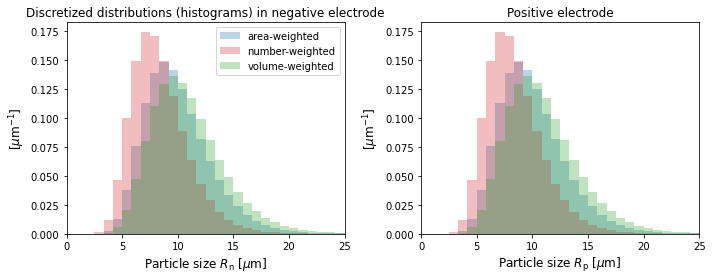

In [6]:
# The discrete sizes or "bins" used
R_p = sim.solution["Positive particle sizes [m]"].entries[:,0,0] # const in the x and current collector direction
R_n = sim.solution["Negative particle sizes [m]"].entries[:,0,0]

# The distributions (number, area, and volume-weighted)
f_a_p = sim.solution["X-averaged positive area-weighted particle-size distribution [m-1]"].entries[:,0]
f_num_p = sim.solution["X-averaged positive number-based particle-size distribution [m-1]"].entries[:,0]
f_v_p = sim.solution["X-averaged positive volume-weighted particle-size distribution [m-1]"].entries[:,0]
f_a_n = sim.solution["X-averaged negative area-weighted particle-size distribution [m-1]"].entries[:,0]
f_num_n = sim.solution["X-averaged negative number-based particle-size distribution [m-1]"].entries[:,0]
f_v_n = sim.solution["X-averaged negative volume-weighted particle-size distribution [m-1]"].entries[:,0]

# plot
f, axs = plt.subplots(1, 2 ,figsize=(10,4))

# negative electrode
width_n = (R_n[-1] - R_n[-2])/ 1e-6
axs[0].bar(R_n / 1e-6, f_a_n * 1e-6, width=width_n, alpha=0.3, color="tab:blue",
           label="area-weighted")
axs[0].bar(R_n / 1e-6, f_num_n * 1e-6, width=width_n, alpha=0.3, color="tab:red",
           label="number-weighted")
axs[0].bar(R_n / 1e-6, f_v_n * 1e-6, width=width_n, alpha=0.3, color="tab:green",
           label="volume-weighted")
axs[0].set_xlim((0,25))
axs[0].set_xlabel("Particle size $R_{\mathrm{n}}$ [$\mu$m]", fontsize=12)
axs[0].set_ylabel("[$\mu$m$^{-1}$]", fontsize=12)
axs[0].legend(fontsize=10)
axs[0].set_title("Discretized distributions (histograms) in negative electrode")

# positive electrode
width_p = (R_p[-1] - R_p[-2])/ 1e-6
axs[1].bar(R_p / 1e-6, f_a_p * 1e-6, width=width_p, alpha=0.3, color="tab:blue",
           label="area-weighted")
axs[1].bar(R_p / 1e-6, f_num_p * 1e-6, width=width_p, alpha=0.3, color="tab:red",
           label="number-weighted")
axs[1].bar(R_p / 1e-6, f_v_p * 1e-6, width=width_p, alpha=0.3, color="tab:green",
           label="volume-weighted")
axs[1].set_xlim((0,25))
axs[1].set_xlabel("Particle size $R_{\mathrm{p}}$ [$\mu$m]", fontsize=12)
axs[1].set_ylabel("[$\mu$m$^{-1}$]", fontsize=12)
axs[1].set_title("Positive electrode")
plt.tight_layout()
plt.show()

## Custom size distributions

Here we show how to change the distribution parameters, or set any distribution of choice. We will set the distribution parameters for the positive distribution (leaving the one for the negative electrode as the default lognormal). We refer to the [MPM notebook](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/models/MPM.ipynb) for more examples.

In [7]:
# Set the area-weighted mean radius to be the reference value from the parameter set
R_av_p_dim = params["Positive particle radius [m]"]

# Standard deviation (dimensional)
sd_p_dim = 0.6 * R_av_p_dim

# Minimum and maximum particle sizes (dimensional)
R_min_p = 0
R_max_p = 3 * R_av_p_dim

# Set the area-weighted particle-size distribution.
# Choose a lognormal (but any pybamm function could be used)


def f_a_dist_p_dim(R):
    return pybamm.lognormal(R, R_av_p_dim, sd_p_dim)

# Note: the only argument must be the particle size R

In [8]:
# input params to the dictionary
distribution_params = {
    "Positive minimum particle radius [m]": R_min_p,
    "Positive maximum particle radius [m]": R_max_p,
    "Positive area-weighted "
    + "particle-size distribution [m-1]": f_a_dist_p_dim,
}
params.update(distribution_params, check_already_exists=False)

Solve and plot 

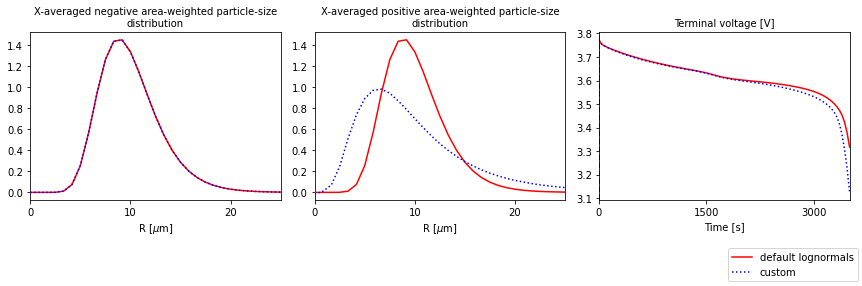

In [9]:
# load parameter values into simulation
sim_custom = pybamm.Simulation(model, parameter_values=params, solver=solver)

# solve
sim_custom.solve(t_eval=[0, 3500])

# plot
output_variables = [
    "X-averaged negative area-weighted particle-size distribution [m-1]",
    "X-averaged positive area-weighted particle-size distribution [m-1]",
    "Voltage [V]"
]
quickplot = pybamm.QuickPlot(
    [sim, sim_custom], output_variables=output_variables, labels=["default lognormals", "custom"]
)
quickplot.plot(0)

## Compare MP-DFN to MPM and DFN models

The MP-DFN is an extension of the MPM (size distributions, but no x variation) and DFN models (x variation, but no size distribution). Here we compare the three for the same parameter values, for a discharge followed by a relaxation. Note: this is implemented here by specifying the current function to be a Heaviside, not using the `Experiment` class.

In [10]:
models = [
    pybamm.lithium_ion.DFN(options={"particle size": "distribution"}, name="MP-DFN"),
    pybamm.lithium_ion.MPM(name="MPM"),
    pybamm.lithium_ion.DFN(name="DFN")
]

# parameters
params = pybamm.ParameterValues("Marquis2019")
params = pybamm.get_size_distribution_parameters(params) 

# define current function
t_cutoff = 3450   # [s]
t_rest = 3600  # [s]
I_typ = params["Nominal cell capacity [A.h]"]  # current for 1C


def current(t):
    return I_typ * pybamm.EqualHeaviside(t, t_cutoff)


params.update({"Current function [A]": current})
t_eval = [0, t_cutoff + t_rest]

# solve
sims = []
for model in models:
    sim = pybamm.Simulation(model, parameter_values=params, solver=solver)
    sim.solve(t_eval=t_eval)
    sims.append(sim)

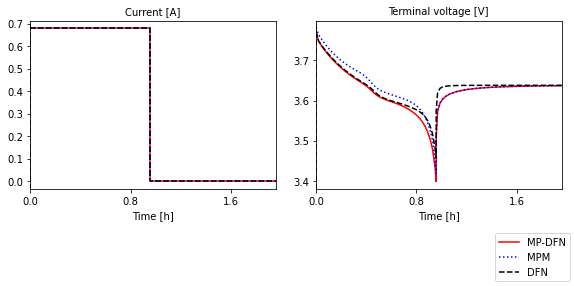

In [11]:
# plot current, voltage 
qp = pybamm.QuickPlot(sims, output_variables=["Current [A]", "Voltage [V]"])
qp.plot(0)

During discharge, the MPM overpredicts the voltage since it neglects the transport (and therefore resistances) through the electrolyte. During the relaxation portion, the DFN overpredicts the rate of relaxation to equilibrium compared to the MP-DFN and MPM. However, the slower relaxation of the size distribution models has been shown to agree better with experiment [[5]](#References).

## References

The relevant papers for this notebook are:

In [12]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[3] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[4] Toby L. Kirk, Jack Evans, Colin P. Please, and S. Jonathan Chapman. Modelling electrode heterogeneity in lithium-ion batteries: unimodal and bimodal particle-size distributions. arXiv:2006.12208, 2020. URL: https://arxiv.org/abs/2006.1